** I used KAGGLE's clod environment to run below codes in steps and downloaded pickle files, so you won't find intermediate cells output. Only chart plot will be there as output.**

In [3]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer




In [2]:
con = sqlite3.connect('./database.sqlite') 

# TEXT PRE-PROCESSING

Used the same code you have provided in notebook

In [3]:
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [4]:
filtered_data.shape

(525814, 10)

In [5]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [12]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [13]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [14]:
final['CleanedText']=final_string


In [16]:
import pickle

final.to_pickle('amazon_food_review_after_preprocess')

In [5]:
final = pd.read_pickle('amazon_food_review_after_preprocess')

In [17]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [18]:
polarity = final['Score']
polarity.shape

(364171,)

# BAG OF WORD


**Considering Cleaned text column for BOW and TF-IDF calculations.**
   *  As we don't want to undetstand semantics meaning of words I am considering CleanedText for BOW and TFIDF. 
   *  In case of W2V I am training W2V so considering RAW TEXT column for training W2V.

In [6]:
count_vect = CountVectorizer() #scikit-learn countevectorizer
final_counts = count_vect.fit_transform(final['CleanedText'].values)

In [7]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [8]:
final_counts

<364171x71624 sparse matrix of type '<class 'numpy.int64'>'
	with 11460537 stored elements in Compressed Sparse Row format>

Sampling from whole dataset as full dataset reuired lots of RAM.

In [9]:
#considering sample of 5000 as KAGGLE killing kernal for long run
test = final_counts[:5000]

In [10]:
test.shape

(5000, 71624)

In [ ]:
#Converting Sparse tto dense matrix for standardization
bow_dense = test.todense()

In [ ]:
#Standardising data
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(bow_dense)
print(standardized_data.shape)

In [ ]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 50,n_iter=5000)
tsne_data = model.fit_transform(standardized_data)

In [ ]:

polarity_1000 = polarity[:5000]
tsne_final = np.vstack((tsne_data.T,polarity_1000)).T
tsne_df = pd.DataFrame(tsne_final,columns=["dim1","dim2","polarity"])
tsne_df.to_pickle("./tsne_5000_50_5000")

In [11]:
tsne_df = pd.read_pickle("./tsne_5000_50_5000")

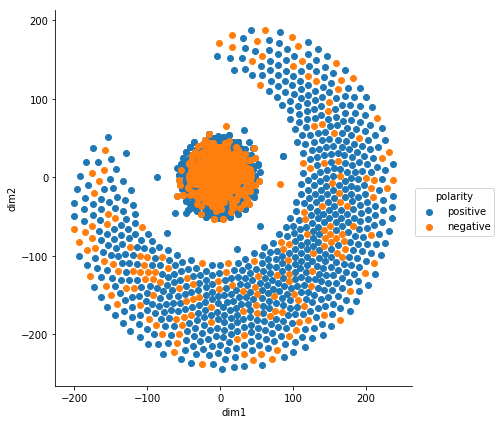

In [14]:
g = sns.FacetGrid(tsne_df,hue="polarity",size = 6)
g = (g.map(plt.scatter,"dim1","dim2")
     .add_legend())

plt.show()

# TF-IDF

In [15]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)

In [16]:
final_tf_idf

<364171x71624 sparse matrix of type '<class 'numpy.float64'>'
	with 11460537 stored elements in Compressed Sparse Row format>

In [17]:
test = final_tf_idf[:5000]

In [18]:
test.shape

(5000, 71624)

In [ ]:
tfidf_dense = test.todense()

In [ ]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(tfidf_dense)
print(standardized_data.shape)

In [ ]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 50,n_iter=5000)
tsne_data_tfidf = model.fit_transform(standardized_data)

In [ ]:
polarity_1000 = polarity[:5000]

In [ ]:
tsne_final = np.vstack((tsne_data.T,polarity_1000)).T

In [ ]:
tsne_df_tfidf = pd.DataFrame(tsne_final,columns=["dim1","dim2","polarity"])

In [ ]:
tsne_df_tfidf.to_pickle("./tsne_tf_idf_5000_50_5000")

In [20]:
tsne_df_tfidf = pd.read_pickle("./tsne_tf_idf_5000_50_5000")

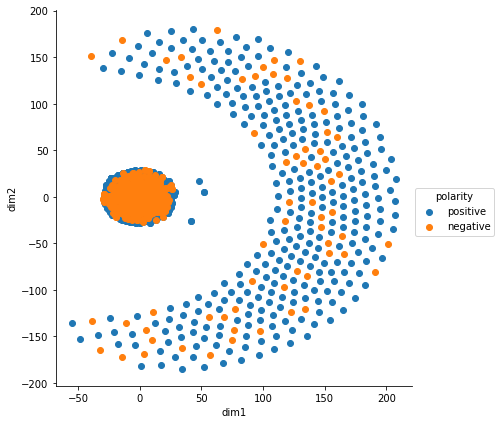

In [21]:
g = sns.FacetGrid(tsne_df_tfidf,hue="polarity",size = 6)
g = (g.map(plt.scatter,"dim1","dim2")
     .add_legend())

plt.show()

** review below. I am doubting below result in case of W2V model.**

# AVG W2V

In [ ]:
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

Training W2V model

In [ ]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

In [ ]:
polarity = final['Score']
polarity.shape

In [ ]:

test = np.array(sent_vectors[:50000],dtype='float64')


In [ ]:

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(test)
print(standardized_data.shape)


In [ ]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 50,n_iter=5000)
tsne_data = model.fit_transform(standardized_data)

In [ ]:
polarity_1000 = polarity[:50000]


In [ ]:
tsne_final = np.vstack((tsne_data.T,polarity_1000)).T


In [ ]:
tsne_df = pd.DataFrame(tsne_final,columns=["dim1","dim2","polarity"])


tsne_df.to_pickle("./tsne_avg_w2v_50000_50_5000")


In [4]:
tsne_df = pd.read_pickle("tsne_avg_w2v_50000_50_5000")

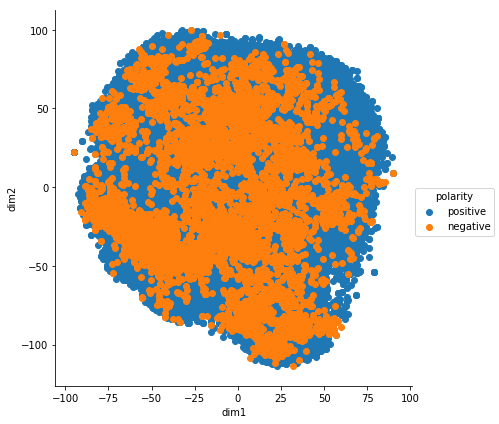

In [5]:
g = sns.FacetGrid(tsne_df,hue="polarity",size = 6)
g = (g.map(plt.scatter,"dim1","dim2")
     .add_legend())

plt.show()

# T-SNE TFIDF W2V

Using above trained W2V model. Considering 10000 samples as it was taking time to execute tf-idf W2V and t-sne and kaggle was killing my kernal.

In [ ]:
list_of_sent_10000 = list_of_sent[:10000]

In Below code you have privided in shared notebook I have found a Typo error at below line.
**weight_sum += tfidf** as you were typed it as tf_idf.

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_10000: # for each review/sentence
    #print(row)
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
           # print("1. {}".format(word))
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            #print(vec * 2)
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            #print(vec * tfidf)
            sent_vec += (vec * tfidf)
           # print(sent_vec)
            #print(tfidf)
            weight_sum += tfidf
            #print(weight_sum)
        except:
            pass
    
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [ ]:
polarity = final['Score']
polarity.shape

In [ ]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(tfidf_sent_vectors)
print(standardized_data.shape)


In [ ]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 50,n_iter=5000)
tsne_data = model.fit_transform(standardized_data)


In [ ]:
polarity_1000 = polarity[:10000]


In [ ]:
tsne_final = np.vstack((tsne_data.T,polarity_1000)).T

In [ ]:
tsne_df = pd.DataFrame(tsne_final,columns=["dim1","dim2","polarity"])


In [ ]:
tsne_df.to_pickle("./tsne_tfidf_w2v_10000_50_5000")

In [6]:
tsne_df = pd.read_pickle("tsne_tfidf_w2v_10000_50_5000")

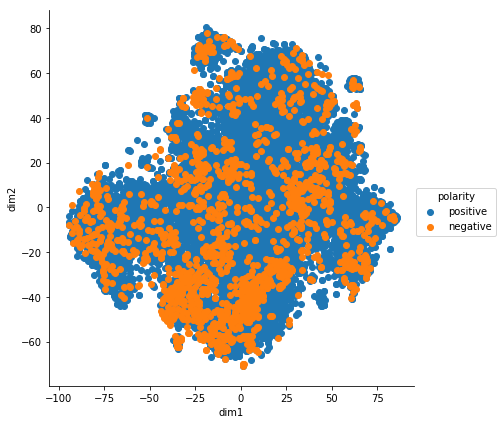

In [7]:
g = sns.FacetGrid(tsne_df,hue="polarity",size = 6)
g = (g.map(plt.scatter,"dim1","dim2")
     .add_legend())

plt.show()